# Analysis of Cancer Gene Expression Data

##### Python main module imports for data analysis

In [1]:
# required modules
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix

### Data Cleaning

##### Choose the data set:

In [2]:
# read data file
datafile = '~/Documents/THESIS/project/ICOS_DATA/breast_preprocessed.txt'
data = pd.read_table(datafile, delim_whitespace = True, 
                     dtype={'a': np.float64}, header = None)

/home/jcapitz/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [3]:
# data dimension
print data.shape
# last 5 rows of the data
data.tail()

(47294, 129)


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
47289,lysA,5.68,5.7194,5.7592,5.6898,5.7236,5.662,5.6684,5.6742,5.6669,...,5.7164,5.7175,5.7133,5.7133,5.6753,5.6679,5.6692,5.7666,5.72,5.75
47290,pheA,5.705,5.6142,5.6955,5.6227,5.6727,5.5995,5.633,5.6539,5.6511,...,5.6595,5.6292,5.6042,5.6266,5.6022,5.6709,5.6136,5.6038,5.6693,5.5818
47291,thrB,5.7077,5.7586,5.7279,5.6777,5.6761,5.7091,5.6777,5.68,5.6763,...,5.6918,5.6501,5.5772,5.6637,5.6556,5.6587,5.6987,5.6933,5.6775,5.68
47292,trpF,5.6684,5.6585,5.6337,5.6427,5.6371,5.6691,5.62,5.6199,5.6608,...,5.6392,5.6451,5.6149,5.551,5.605,5.6246,5.5404,5.6206,5.6552,5.6141
47293,y,luminal,luminal,luminal,luminal,luminal,non-luminal,non-luminal,luminal,luminal,...,luminal,luminal,luminal,non-luminal,non-luminal,luminal,luminal,luminal,non-luminal,luminal


In [4]:
import thefunc as fu

In [5]:
# extract colum names (all but last one are gene names).
colNames = data[0]
colNames = list(colNames)

In [6]:
# check for housekeepnig genes
fu.housekeepgenes('HK_exons.csv',data)

there are 0 house keeping genes.


In [7]:
X,Y = fu.data_engineer(data,colNames)

In [8]:
# store the gene names/ids
geneNames = X.columns

In [9]:
#Percent of cancer positive
np.mean(Y)

0.65625

## Classification with Penalized Logistic Model

In [10]:
#score_dict = fu.penalty_selector(X,Y,10)
#cv_results = DataFrame.from_dict(data=score_dict, orient='columns', dtype=None).sort(columns = 'accuracy', 
#                                                                                     ascending=False)
#cv_results.to_csv('cv_results.csv')

cv_results = pd.read_csv('cv_results.csv')
print cv_results.iloc[0,2]
print cv_results.iloc[0,3]
cv_results.head()

0.233952406474
0.45


,Unnamed: 0,accuracy,alpha,l1_ratio
0,2448,0.890476,0.233952,0.45
1,2319,0.890476,0.088371,1.00
2,2490,0.883333,0.308982,0.55
3,2394,0.882143,0.154141,0.75
4,2454,0.873810,0.233952,0.75


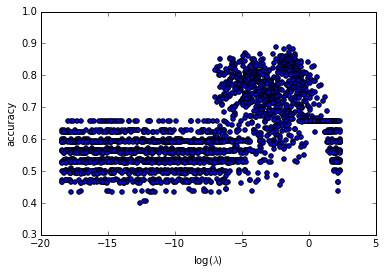

In [11]:
plt.scatter(np.log(cv_results['alpha']),cv_results['accuracy'])
plt.xlabel('log($\lambda$)')
plt.ylabel('accuracy')
plt.show()

In [ ]:
# l1_ratio refers to alpha and alpha refers to lamba in Hastie
penalty = cv_results.iloc[1,2]
mix = cv_results.iloc[1,3]
#penalty = 0.175
#mix = 0.5
#log_model = LogisticRegression(penalty = 'l1', C = 1/penalty)
log_model = SGDClassifier(loss = 'log', penalty = 'elasticnet', alpha = penalty, l1_ratio = mix, 
                          fit_intercept = True)

In [55]:
penalty

0.088370787436099996

### Significant Gene Selection Cross-Validation

In [13]:
selectResult = fu.geneSelector(X,Y,log_model,500)

In [14]:
gene_coeff = selectResult['coeff']
gene_select_count = selectResult['frequency']

In [15]:
threshold = 0.0
results, feature_select_summary = fu.param_calculator(geneNames,gene_coeff,gene_select_count,threshold)

In [16]:
#results.to_csv('results.csv')

#feature_select_summary.to_csv('feature_select_summary.csv')

#results = pd.read_csv('results.csv')
#feature_select_summary = pd.read_csv('feature_select_summary.csv')

In [17]:
results[['Feature', 'Frequency', 'Coefficient', 'Std Error', 'pvalue']].head()


,Feature,Frequency,Coefficient,Std Error,pvalue
22089,GI_4503602-S,500,15.69317,4.428179,0.0001971022
26033,GI_9951924-S,500,8.712548,3.583478,0.007522154
17275,GI_38455428-S,499,10.55841,4.283188,0.006849106
22149,GI_4503928-S,499,8.524765,3.867105,0.01374703
10064,GI_29738585-S,499,7.698219,3.042416,0.005698277


In [18]:
results.head()

,Feature,Frequency,Score,Coefficient,Std Error,pvalue
22089,GI_4503602-S,500,15.69317,15.69317,4.428179,0.0001971022
26033,GI_9951924-S,500,8.712548,8.712548,3.583478,0.007522154
17275,GI_38455428-S,499,10.55841,10.55841,4.283188,0.006849106
22149,GI_4503928-S,499,8.524765,8.524765,3.867105,0.01374703
10064,GI_29738585-S,499,7.698219,7.698219,3.042416,0.005698277


In [19]:
GI_4503602_S = X['GI_4503602-S']
GI_38455428_S = X['GI_38455428-S']
GI_21614543_S = X['GI_21614543-S']
GI_29738585_S = X['GI_29738585-S']

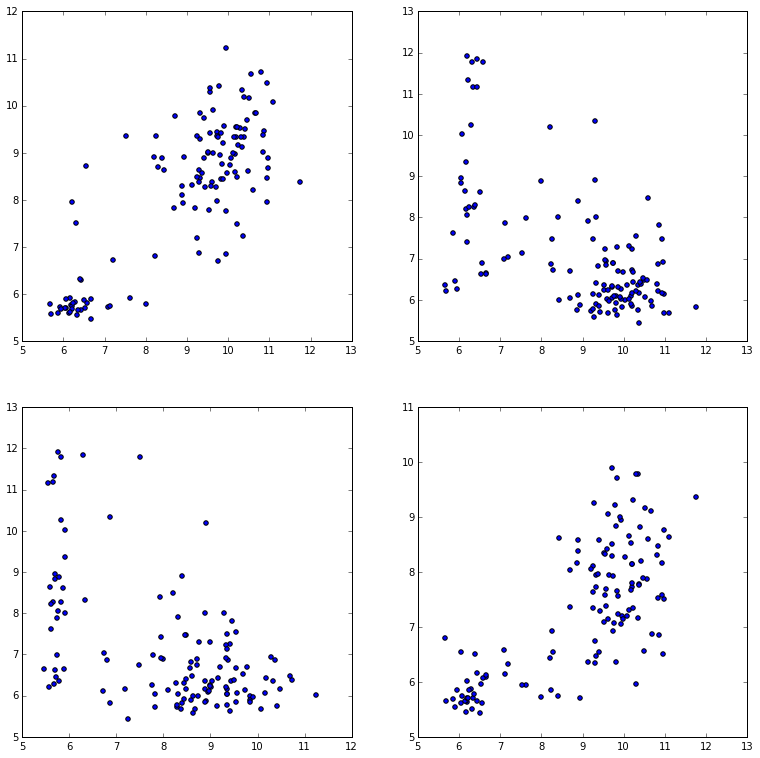

In [20]:
plt.figure(figsize=(13,13))
plt.subplot(2,2,1)
plt.scatter(GI_4503602_S,GI_38455428_S)
plt.subplot(2,2,2)
plt.scatter(GI_4503602_S,GI_21614543_S)
plt.subplot(2,2,3)
plt.scatter(GI_38455428_S,GI_21614543_S)
plt.subplot(2,2,4)
plt.scatter(GI_4503602_S,GI_29738585_S)
plt.show()

In [21]:
print len(results['Feature'])
results[['Feature', 'Frequency', 'Coefficient', 'Std Error', 'pvalue']].head(4)

4897


,Feature,Frequency,Coefficient,Std Error,pvalue
22089,GI_4503602-S,500,15.69317,4.428179,0.0001971022
26033,GI_9951924-S,500,8.712548,3.583478,0.007522154
17275,GI_38455428-S,499,10.55841,4.283188,0.006849106
22149,GI_4503928-S,499,8.524765,3.867105,0.01374703


In [22]:
#Need to create X_sel

X_sel = X[results.index]

In [23]:
#X_sel.to_csv('X_sel.csv')

#X_sel = pd.read_csv('X_sel.csv')

X_sel.head()

,GI_4503602-S,GI_9951924-S,GI_38455428-S,GI_4503928-S,GI_29738585-S,GI_21614543-S,GI_14249703-S,GI_22748948-S,GI_22035691-A,GI_12751474-S,...,GI_37551880-S,GI_16933547-A,GI_27754193-S,GI_21389406-S,GI_8923268-S,GI_21327686-A,GI_13929469-S,GI_34222313-S,GI_27735136-S,GI_33591068-S
0,9.7077,10.0794,8.2690,11.0795,9.8838,6.3119,8.8984,8.7025,8.8121,7.9952,...,5.5899,10.7503,9.8365,6.4830,6.3325,7.2887,6.8099,7.4861,6.0613,6.7811
1,9.3272,9.3713,8.4707,10.3874,6.4782,6.4005,6.9269,8.2001,6.5192,8.3787,...,5.7558,10.8157,9.2151,7.0431,6.6597,7.1123,6.7245,8.4240,5.8689,7.3083
2,9.7234,10.1479,9.4392,10.3963,8.2889,6.3478,7.5639,8.3683,7.5663,8.8702,...,5.8589,10.0723,9.3193,6.7428,6.6274,7.0306,7.3103,7.7591,5.8311,7.5771
3,10.9760,9.9660,8.8842,10.7271,7.4989,6.1547,7.7943,8.7432,7.0302,8.7270,...,5.6328,10.4618,9.7743,6.8728,6.2690,7.1720,6.7695,8.0487,6.0812,7.6363
4,10.6502,9.8026,9.8455,10.7180,9.1028,5.9851,7.8930,8.3768,8.6986,9.2759,...,5.7412,10.3265,9.4825,6.8301,6.4697,6.8266,6.7101,8.2140,5.8324,7.4357


In [24]:
#X_sel.drop('Unnamed: 0', inplace=True, axis = 1)

In [25]:
X_sel.head()

,GI_4503602-S,GI_9951924-S,GI_38455428-S,GI_4503928-S,GI_29738585-S,GI_21614543-S,GI_14249703-S,GI_22748948-S,GI_22035691-A,GI_12751474-S,...,GI_37551880-S,GI_16933547-A,GI_27754193-S,GI_21389406-S,GI_8923268-S,GI_21327686-A,GI_13929469-S,GI_34222313-S,GI_27735136-S,GI_33591068-S
0,9.7077,10.0794,8.2690,11.0795,9.8838,6.3119,8.8984,8.7025,8.8121,7.9952,...,5.5899,10.7503,9.8365,6.4830,6.3325,7.2887,6.8099,7.4861,6.0613,6.7811
1,9.3272,9.3713,8.4707,10.3874,6.4782,6.4005,6.9269,8.2001,6.5192,8.3787,...,5.7558,10.8157,9.2151,7.0431,6.6597,7.1123,6.7245,8.4240,5.8689,7.3083
2,9.7234,10.1479,9.4392,10.3963,8.2889,6.3478,7.5639,8.3683,7.5663,8.8702,...,5.8589,10.0723,9.3193,6.7428,6.6274,7.0306,7.3103,7.7591,5.8311,7.5771
3,10.9760,9.9660,8.8842,10.7271,7.4989,6.1547,7.7943,8.7432,7.0302,8.7270,...,5.6328,10.4618,9.7743,6.8728,6.2690,7.1720,6.7695,8.0487,6.0812,7.6363
4,10.6502,9.8026,9.8455,10.7180,9.1028,5.9851,7.8930,8.3768,8.6986,9.2759,...,5.7412,10.3265,9.4825,6.8301,6.4697,6.8266,6.7101,8.2140,5.8324,7.4357


In [26]:
# this gives the model's score
log_model.fit(X_sel,Y)
print log_model.score(X_sel,Y)

0.8984375


In [27]:
class_prob = log_model.predict_proba(X_sel)

In [28]:
dfprob = DataFrame(class_prob)
print dfprob.mean()

0    0.289062
1    0.710938
dtype: float64


### Mean Accuracy

In [29]:
model2 = LogisticRegression(dual = False, fit_intercept = True)
mean_acc, std_acc, mean_roc, std_roc = fu.accuracy_calculator(model2,X_sel,Y,1000)
print mean_acc
print mean_roc

0.8671875
0.839793896404


In [30]:
np.corrcoef(X_sel)

array([[ 1.        ,  0.88503227,  0.8764389 , ...,  0.76965038,
         0.74462439,  0.80382207],
       [ 0.88503227,  1.        ,  0.92293962, ...,  0.78096167,
         0.80273796,  0.87026332],
       [ 0.8764389 ,  0.92293962,  1.        , ...,  0.7711906 ,
         0.80268847,  0.89212174],
       ..., 
       [ 0.76965038,  0.78096167,  0.7711906 , ...,  1.        ,
         0.84843093,  0.81814772],
       [ 0.74462439,  0.80273796,  0.80268847, ...,  0.84843093,
         1.        ,  0.81824017],
       [ 0.80382207,  0.87026332,  0.89212174, ...,  0.81814772,
         0.81824017,  1.        ]])

# Network Inference

In [31]:
results_top10 = results.head(100)
X_top10 = X[results_top10.index]
X_top10.shape[1]

100

In [32]:
#adj_mat = adjecency_penalized_reg(X_sel)

In [33]:
#np.savetxt("adj_mat.csv", adj_mat, delimiter=",")

In [34]:
W = np.genfromtxt('adj_mat.csv',delimiter = ',')

In [35]:
W.shape

(1017, 1017)

In [36]:
W.trace()

0.0

# Spectral Clustering

In [37]:
from sklearn.cluster import SpectralClustering
import matplotlib.cm as cm

In [38]:
spclus = SpectralClustering(affinity='precomputed', n_clusters=2, assign_labels='discretize')
spclus_pred = spclus.fit_predict(W)
print spclus_pred[:100]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/home/jcapitz/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:578: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


In [39]:
spclus_pred.shape

(1017,)

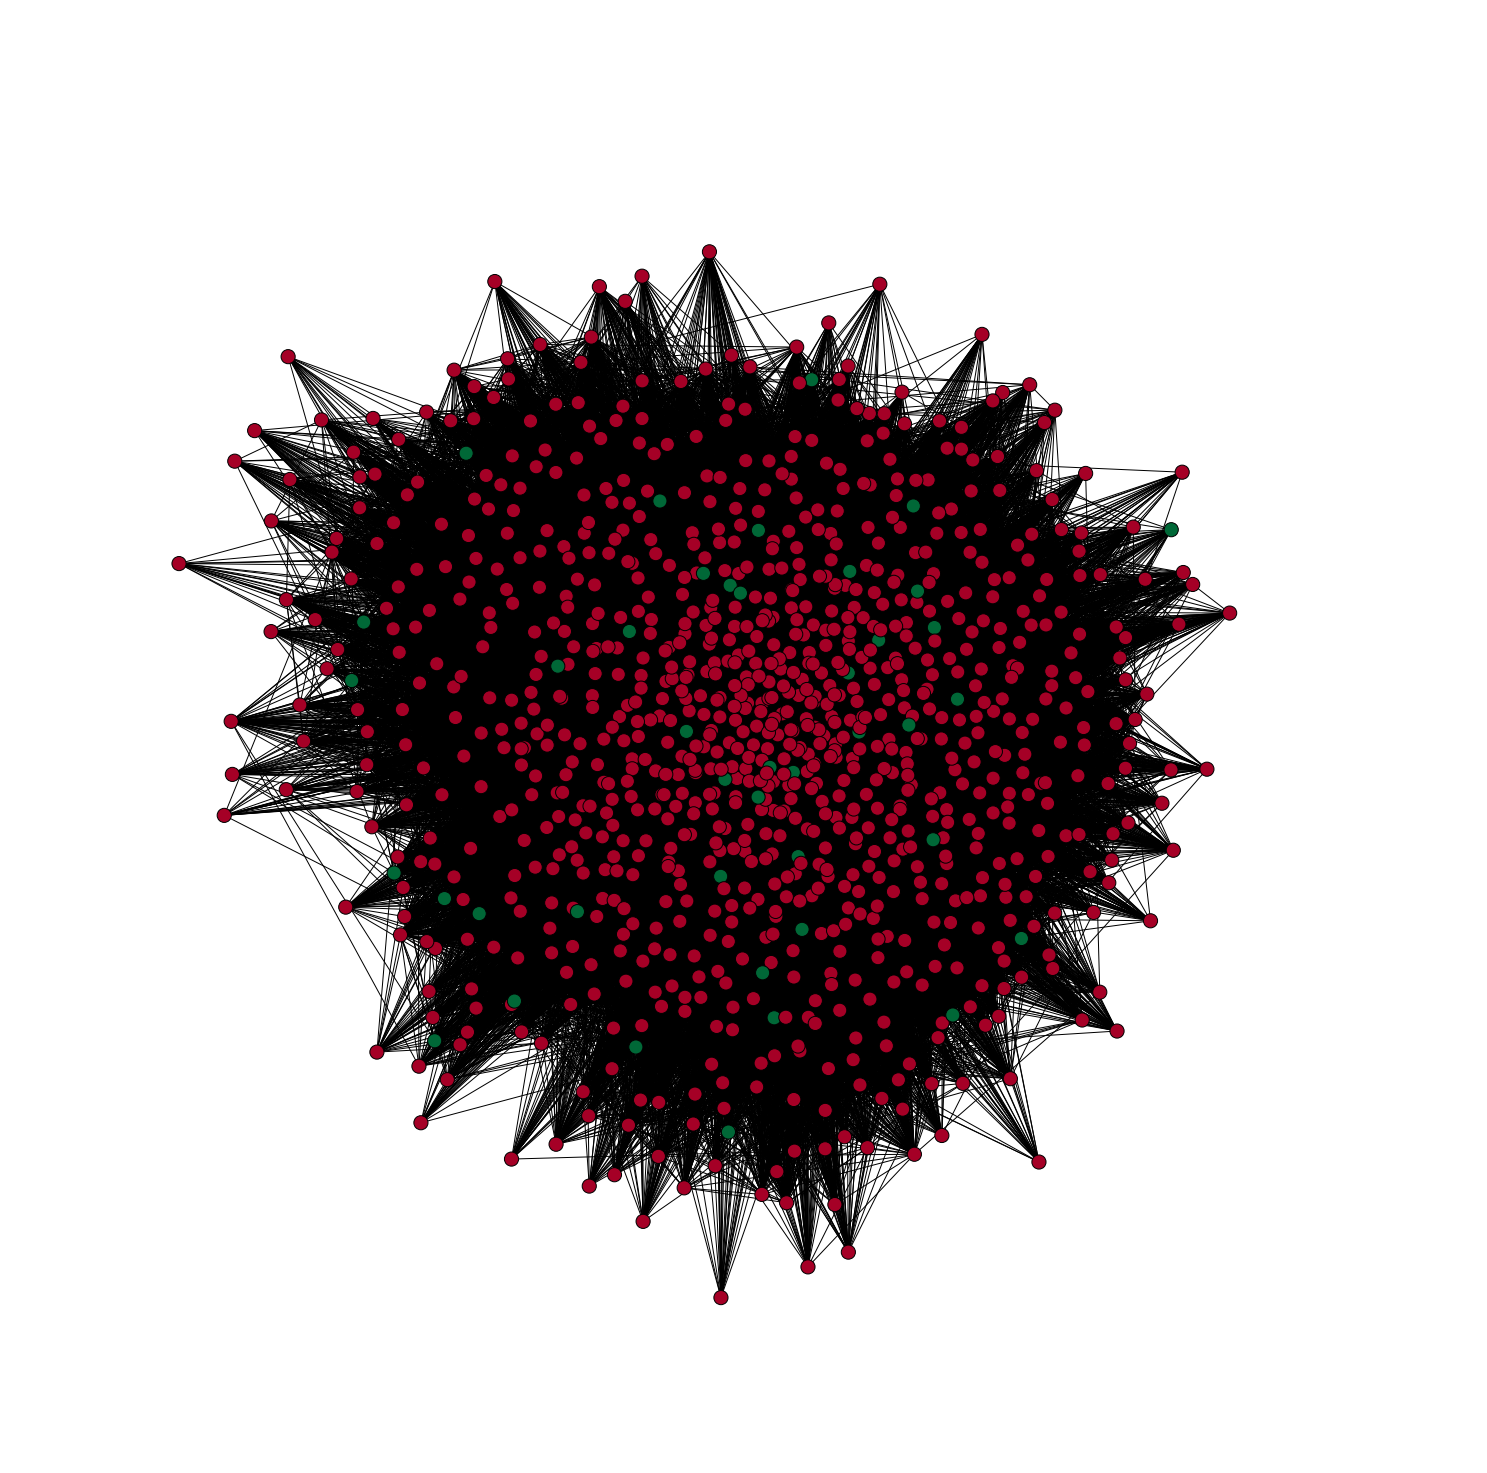

In [40]:
import networkx as nx
#G = nx.from_scipy_sparse_matrix(W)
G = nx.from_numpy_matrix(W)

node_labels = X_sel.columns
mapping = dict(zip(G.nodes(), node_labels))
G = nx.relabel_nodes(G,mapping, copy=False)

node_colors= spclus_pred
plt.figure(figsize=(20,20))
nx.draw(G, node_size = 200, node_color = spclus_pred, cmap=cm.RdYlGn) #cmap = 'jet')

In [41]:
X_top10.head()

,GI_4503602-S,GI_9951924-S,GI_38455428-S,GI_4503928-S,GI_29738585-S,GI_21614543-S,GI_14249703-S,GI_22748948-S,GI_22035691-A,GI_12751474-S,...,Hs.449602-S,GI_20070225-S,GI_13112049-A,GI_45505179-S,GI_22538813-S,GI_21536300-I,GI_31377630-S,GI_37595559-S,GI_27477718-S,GI_31543421-S
0,9.7077,10.0794,8.2690,11.0795,9.8838,6.3119,8.8984,8.7025,8.8121,7.9952,...,9.5091,8.5476,6.0271,6.7182,8.0855,8.9482,6.3775,8.2930,9.0727,5.8257
1,9.3272,9.3713,8.4707,10.3874,6.4782,6.4005,6.9269,8.2001,6.5192,8.3787,...,9.6639,7.5400,6.5290,7.4923,8.5864,7.7037,6.2840,7.4366,9.3995,6.1093
2,9.7234,10.1479,9.4392,10.3963,8.2889,6.3478,7.5639,8.3683,7.5663,8.8702,...,10.8437,7.4654,6.0237,7.3292,8.2719,8.0830,6.3127,7.5052,10.3084,6.1011
3,10.9760,9.9660,8.8842,10.7271,7.4989,6.1547,7.7943,8.7432,7.0302,8.7270,...,9.4107,7.5479,5.6654,7.3381,6.9848,7.2917,6.0076,6.7036,10.7058,6.1490
4,10.6502,9.8026,9.8455,10.7180,9.1028,5.9851,7.8930,8.3768,8.6986,9.2759,...,9.7339,8.0475,6.1477,7.7283,7.9134,8.1911,5.9786,7.3933,10.4065,5.7342


In [42]:
G['GI_4503602-S'];

In [43]:
len(G.neighbors('GI_4503602-S'))

356

In [44]:
G.size()

81612

### Power Law Analysis

In [45]:
deg = G.degree().values()
print len(deg)
deg[:3]

1017


[170, 166, 37]

1017


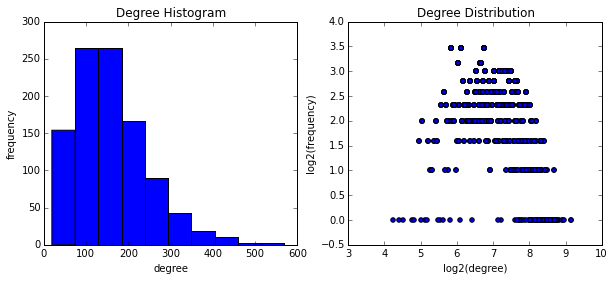

In [46]:
freq = [deg.count(x) for x in deg]

print len(deg)

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.hist(deg, bins = 10)
plt.title('Degree Histogram')
plt.xlabel('degree')
plt.ylabel('frequency')

plt.subplot(1,2,2)
plt.scatter(np.log2(deg),np.log2(freq))
plt.title('Degree Distribution')
plt.xlabel('log2(degree)')
plt.ylabel('log2(frequency)')
plt.show()

In [47]:
histo = nx.degree_histogram(G)
count = 0
d = 29
for d in range(1,d):
    count += histo.count(d)
print count


307


##### Most Connected

In [48]:
print max(deg)

569


In [49]:
# find the position of highest degree node in degree value list
degarray = np.asarray(deg)
np.where(degarray == 91)

(array([148, 224, 575, 657, 667, 766]),)

In [50]:
deg[213]

209

###### Tail probabilities:
$$\bar{F}\left(d\right) = 1-F\left(d\right)\sim d^{-\left(\alpha - 1\right)}$$
###### Estimate $\alpha$

###### The MLE of $\alpha$ is:
$$\hat{\alpha}_k = 1 + \hat{\gamma}_k^{-1}$$

###### With:
$$\hat{\gamma}_k = \frac{1}{k} \sum_{i=0}^{k-1} \log{\frac{d_\left(N_v-i\right)}{d_\left(N_v-k\right)}}$$

In [51]:
def alphaK(deg,k):
    deg.sort()
    degorder = np.asarray(deg)
    gammaK = sum(np.log(degorder[-k:]/float(degorder[len(deg) - k])))/k
    alpha = 1 + gammaK**-1
    return alpha

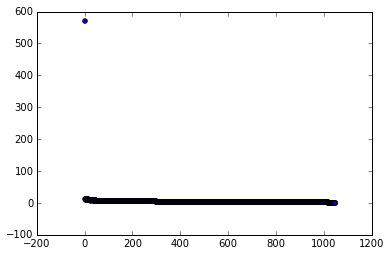

In [52]:
kvec = range(2,1049)
alpha = [alphaK(deg,i) for i in kvec]

plt.scatter(kvec,alpha)
plt.show()

In [53]:
alphaK(deg,2)

568.99941314503701

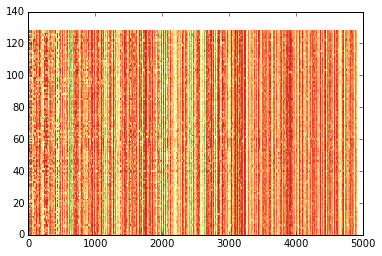

In [54]:
plt.pcolor(X_sel, cmap=cm.RdYlGn)
plt.show()

## Constructing a Markov Random Field